## Import Necesary Libraries

In [107]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense,Input, Embedding
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import warnings
warnings.filterwarnings('ignore')



In [108]:
data = pd.read_csv('/kaggle/input/final-one/nepali_english.csv')
data.head()

,Unnamed: 0,English,Nepali
0,0,go,जानुहोस्
1,1,hi,नमस्ते
2,2,hi,नमस्ते
3,3,run,दौडनु
4,4,run,दौडनु


In [109]:
data.drop('Unnamed: 0',axis = 1,inplace = True)

In [110]:
# counting sources
data['English'].value_counts()

go away                                        37
get lost                                       18
get away                                       18
beat it                                        17
just check it                                  12
                                               ..
tom grabbed it                                  1
tom grew roses                                  1
tom grows rice                                  1
tom had a plan                                  1
The percentage change is since year-end .\n     1
Name: English, Length: 18998, dtype: int64

In [111]:
print("Total data: ",data.shape[0])

Total data:  25453


In [112]:
# checking null values
data.isna().sum()

English    0
Nepali     0
dtype: int64

In [113]:
# checking duplicated data
isDuplicated = data.duplicated().any()
if isDuplicated:
    total_duplicates = data.duplicated().sum()
    print("Total duplicate rows are: ",total_duplicates)
    data.drop_duplicates(inplace = True)

Total duplicate rows are:  6455


In [114]:
data.shape

(18998, 2)

In [115]:
data.columns

Index(['English', 'Nepali'], dtype='object')

In [116]:
data = data.rename(columns = {'English':'english_sentence','Nepali':"nepali_sentence"})

## Text preprocessing

In [117]:
# remove data containing tom
data = data[data["english_sentence"].str.contains("tom") == False]
patternDel = 'a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z'
data = data[data["nepali_sentence"].str.contains(patternDel) == False]
data.shape

(14222, 2)

In [118]:
## changing uppercase to lowercase
data['english_sentence'] = data['english_sentence'].apply(lambda x: x.lower())
data['nepali_sentence']=data['nepali_sentence'].apply(lambda x: x.lower())

# Remove quotes
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub("'", ' ', x))
data['nepali_sentence']=data['nepali_sentence'].apply(lambda x: re.sub("'", ' ', x))


In [119]:
to_exclude = set(string.punctuation) # Set of all special characters
print("punctuations to exclude:: ",to_exclude)
# Remove all the special characters
data['english_sentence']=data['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))
data['nepali_sentence']=data['nepali_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))

punctuations to exclude::  {'^', '|', '$', '!', '=', '-', ',', '_', '+', '"', '`', '{', ')', '&', '<', '@', '>', '[', '}', '.', '#', "'", ';', '?', ':', '(', ']', '%', '*', '~', '\\', '/'}


In [120]:
from string import digits
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)

data['english_sentence']=data['english_sentence'].apply(lambda x: x.translate(remove_digits))
data['nepali_sentence']=data['nepali_sentence'].apply(lambda x: x.translate(remove_digits))

data['nepali_sentence'] = data['nepali_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
data['english_sentence']=data['english_sentence'].apply(lambda x: x.strip())
data['nepali_sentence']=data['nepali_sentence'].apply(lambda x: x.strip())
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
data['nepali_sentence']=data['nepali_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [121]:
## adding start and end token to the target sentence
data['nepali_sentence'] = data['nepali_sentence'].apply(lambda x: "START_ " + x + " _END")

In [122]:
## counting length of english and hindi sentence
data['english_length'] = data['english_sentence'].apply(lambda x: len(x.split(' ')))
data['nepali_length'] = data['nepali_sentence'].apply(lambda x: len(x.split(' ')))

data.head()

,english_sentence,nepali_sentence,english_length,nepali_length
0,go,START_ जानुहोस् _END,1,3
1,hi,START_ नमस्ते _END,1,3
3,run,START_ दौडनु _END,1,3
5,wow,START_ वाह _END,1,3
7,duck,START_ हाँस _END,1,3


In [123]:
print("Maximum length of English Sentence: ", max(data['english_length']))
print("Maximum length of Nepali Sentence: ",max(data['nepali_length']))

Maximum length of English Sentence:  54
Maximum length of Nepali Sentence:  58


In [124]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in data['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_nepali_words=set()
for hin in data['nepali_sentence']:
    for word in hin.split():
        if word not in all_nepali_words:
            all_nepali_words.add(word)
            

print("total english words: ",len(all_eng_words))
print('total nepali words: ',len(all_nepali_words))

total english words:  5157
total nepali words:  7595


In [125]:
## using only sentence with length less than 13
mask1 = data['english_length'] < 13
mask2 = data['nepali_length'] < 13
data = data[mask1 & mask2]
data.shape

(13894, 4)

In [126]:
print("maximum length of nepali Sentence ",max(data['nepali_length']))
print("maximum length of English Sentence ",max(data['english_length']))

maximum length of nepali Sentence  12
maximum length of English Sentence  12


In [127]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_nepali_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_nepali_words)

num_encoder_tokens, num_decoder_tokens

(5157, 7595)

In [128]:
num_decoder_tokens += 1 #for zero padding


In [129]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])



In [130]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
print("Character for token 50 is: ",reverse_input_char_index[50])

Character for token 50 is:  actor


In [131]:
# splitting data
X_, y_ = data['english_sentence'], data['nepali_sentence']
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2,random_state=42)
print("Total number of training data: ",X_train.shape[0])
print("Toral number of testing data: ",X_test.shape[0])

Total number of training data:  11115
Toral number of testing data:  2779


In [132]:
latent_dim = 600
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 600)    3094200     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 600)    4557600     input_8[0][0]                    
____________________________________________________________________________________________

In [133]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

In [134]:
max_length_src = 20
max_length_tar = 20 

def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [135]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 20

In [136]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/20
86/86 [==============================] - 25s 208ms/step - loss: 1.0932 - accuracy: 0.2800 - val_loss: 0.9493 - val_accuracy: 0.3120
Epoch 2/20
86/86 [==============================] - 15s 176ms/step - loss: 0.8694 - accuracy: 0.3538 - val_loss: 0.8273 - val_accuracy: 0.4139
Epoch 3/20
86/86 [==============================] - 16s 182ms/step - loss: 0.7357 - accuracy: 0.4476 - val_loss: 0.7452 - val_accuracy: 0.4732
Epoch 4/20
86/86 [==============================] - 15s 177ms/step - loss: 0.6365 - accuracy: 0.5069 - val_loss: 0.6993 - val_accuracy: 0.5075
Epoch 5/20
86/86 [==============================] - 16s 182ms/step - loss: 0.5572 - accuracy: 0.5530 - val_loss: 0.6531 - val_accuracy: 0.5423
Epoch 6/20
86/86 [==============================] - 15s 178ms/step - loss: 0.4884 - accuracy: 0.5933 - val_loss: 0.6203 - val_accuracy: 0.5682
Epoch 7/20
86/86 [==============================] - 16s 182ms/step - loss: 0.4286 - accuracy: 0.6305 - val_loss: 0.6010 - val_accuracy: 0.5802

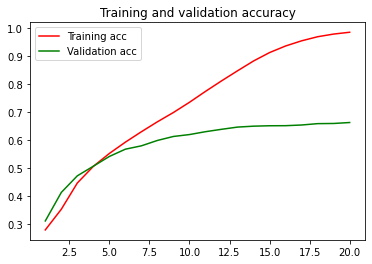

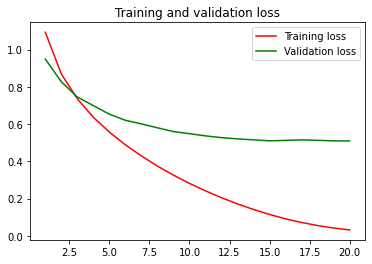

In [150]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 21)

plt.plot(epochs, acc, '-',color = 'red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color = 'green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-',color = 'red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color = 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [137]:
# Encode the input sequence to get the "thought vectors"
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


## to save the mode
decoder_model.save("Decoder_model.h5")
encoder_model.save("Encoder_model.h5")
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [138]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k = -1

In [139]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: she looks sad
Actual Nepali Translation:  उनी उदास देखिन्छिन् 
Predicted Nepali Translation:  उनी उदास देखिन्छिन् 


In [140]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: i have to take it
Actual Nepali Translation:  मैले लिनुपर्छ 
Predicted Nepali Translation:  मैले लुकाउनु पर्छ 


In [141]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: can you read that
Actual Nepali Translation:  तपाईं त्यो पढ्न सक्नुहुन्छ 
Predicted Nepali Translation:  तपाईं त्यो पढ्न सक्नुहुन्छ 


In [142]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: show yourself
Actual Nepali Translation:  आफैलाई देखाउनुहोस् 
Predicted Nepali Translation:  आफैलाई देखाउनुहोस् 


In [143]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: i have one
Actual Nepali Translation:  मसँग एउटा छ 
Predicted Nepali Translation:  मसँग एउटा छ 


In [144]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: no one is home
Actual Nepali Translation:  घर कोही छैन 
Predicted Nepali Translation:  घर कोही छैन 


In [151]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])



Input English sentence: are we done
Actual Nepali Translation:  हामीले गरिसकेका छौं 
Predicted Nepali Translation:  हामीले गरिसकेका छौं 


In [152]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])

Input English sentence: she looked sad
Actual Nepali Translation:  उनी उदास देखिन्थिन् 
Predicted Nepali Translation:  उनी उदास देखिन्थिन् 


In [154]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Nepali Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Nepali Translation:', decoded_sentence[:-4])



Input English sentence: i was left behind
Actual Nepali Translation:  म पछाडि छोडिएँ 
Predicted Nepali Translation:  म पछाडि छोडिएँ 


In [155]:
## to save token index 
import json
with open("input_token_index.json", "w") as f:
    json.dump(input_token_index, f)
with open("target_token_index.json", "w") as f:
    json.dump(target_token_index, f)

In [159]:
while True:
    
    text = input("Enter any english text:")
    if text.lower() == 'exit':
        break
    text = text.lower().split()
    ls = np.zeros((1,20))[0].tolist()
    i = 0
    for word in text:
        ls[i] = (input_token_index[word])
        i = i + 1

    inputs = np.array([ls])
    print("Nepali Text is: ",decode_sequence(inputs)[:-4])


    

Enter any english text: hello


Nepali Text is:   नमस्कार 


Enter any english text: hi


Nepali Text is:   नमस्ते 


Enter any english text: how are you


Nepali Text is:   तिमी कस्तो छौ 


Enter any english text: who are you


Nepali Text is:   को को हो 


Enter any english text: what are you doing


Nepali Text is:   तिमी के गर्दै हो 


Enter any english text: I am alone


Nepali Text is:   म एक्लै छु 


Enter any english text: I love her


Nepali Text is:   म उनलाई माया गर्छु 


Enter any english text: she is beautiful


Nepali Text is:   उनी सुन्दर छिन् 


Enter any english text: I like fish


Nepali Text is:   मलाई माछा मन पर्छ 


Enter any english text: who are they


Nepali Text is:   को हुन हुन् 


Enter any english text: what does she like


Nepali Text is:   उनी के गर्छिन् 


Enter any english text: I was alone


Nepali Text is:   म एक्लै थिएँ 


Enter any english text: I am alone


Nepali Text is:   म एक्लै छु 


Enter any english text: I was left


Nepali Text is:   म विजयी भएँ 


Enter any english text: exit
